# Program Assignment #1 - Naïve Bayes part1 (mushroom dataset)
---

## Name: 李勝維
## Student ID: 0711239

### Part1 for mushroom dataset

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load data & preprocessing

我把 data visualization 放在最後面，因為有很多張圖

## code講解：

首先將資料讀取data，並將透過字母表示的資料encode成數字（EX： a->1, b->2... ）

最後再shuffle data

In [2]:
# load mushroom dataset
raw_data = pd.read_csv('data/agaricus-lepiota.data', header=None).values
x, y = raw_data[..., 1:], raw_data[..., 0]

# delete columns with '?' value in it
for something_missing in np.unique(np.where(x == '?')[1]):
    x = np.delete(x, something_missing, 1)

# transform label/features from char -> int
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)

x_encoder = OrdinalEncoder()
x = x_encoder.fit_transform(x); x = x.astype(y.dtype)

# shuffle data
from sklearn.utils import shuffle
x, y = shuffle(x, y)

# Model Construction
## 1. clf_wo: without laplace smoothing
## 2. clf_w:  with laplace smoothing

(clf stands for classifier)

其中 min_categories 變數是為了避免經過shuffle後，訓練資料可能不會包含所有種類的feature，造成錯誤

In [3]:
from sklearn.naive_bayes import CategoricalNB
import warnings;warnings.filterwarnings("ignore")
min_categories = [np.max(x[..., col])+1 for col in range(x.shape[1])]
# without laplace smoothing
clf_wo = CategoricalNB(alpha=0.0, min_categories=min_categories)
# with laplace smoothing
clf_w = CategoricalNB(alpha=1.0, min_categories=min_categories)

# Train-Test-Split  
這邊定義了使用 Hold-out 和 Kfold 兩種驗證方法的函數  
透過使用sklearn.metrics中的函數來實作，其中sensitivity和precision是分別求不同class分別當成positive後，取平均值  
最後使用了 tabulate 套件來畫表格

In [4]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from tabulate import tabulate

def hold_out(clf,name, x, y, ratio=(0.7, 0.3)):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=ratio[1])
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    table_data = [
        ("poisonous", tp, fp),
        ("edible", fn, tn),
    ]
    print(tabulate(table_data, headers=(f"Confusion matrix\n{name}", "Positive", "Negative"), tablefmt="grid"))
    print()
    return accuracy, sensitivity, precision

def k_fold(clf,name, x, y, k=3):
    kf = KFold(n_splits=k)
    ans = np.array([0,0,0,0])
    for train_idx, test_idx in kf.split(x):
        x_train, x_test, y_train, y_test = x[train_idx], x[test_idx], y[train_idx], y[test_idx]
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        ans = ans + confusion_matrix(y_test, y_pred).ravel()
    ans = ans / 3
    tn, fp, fn, tp = ans
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    
    table_data = [
        ("poisonous", tp, fp),
        ("edible", fn, tn),
    ]
    print(tabulate(table_data, headers=(f"Confusion matrix\n{name}", "Positive", "Negative"), tablefmt="grid"))
    print()
    return accuracy, sensitivity, precision

# Result display

In [5]:
table_data = []
print("Holdout validation:")
table_data.append(("Holdout w/o smoothing" ,*hold_out(clf_wo, "w/o smoothing", x, y)))
table_data.append(("Holdout w/  smoothing" ,*hold_out(clf_w, "w/  smoothing", x, y)))

print("K-fold cross-validation:")
table_data.append((("K-fold  w/o smoothing"), *k_fold(clf_wo, "w/o smoothing", x, y)))
table_data.append((("K-fold  w/  smoothing"), *k_fold(clf_w, "w/  smoothing", x, y)))

print("Final results:")
print(tabulate(table_data, headers=("Test settings", "Accuracy", "Sensitivity (Average)", "Precision (Average)"), tablefmt="grid"))

Holdout validation:
+--------------------+------------+------------+
| Confusion matrix   |   Positive |   Negative |
| w/o smoothing      |            |            |
+====================+============+============+
| poisonous          |       1185 |         11 |
+--------------------+------------+------------+
| edible             |          1 |       1241 |
+--------------------+------------+------------+

+--------------------+------------+------------+
| Confusion matrix   |   Positive |   Negative |
| w/  smoothing      |            |            |
+====================+============+============+
| poisonous          |       1124 |          7 |
+--------------------+------------+------------+
| edible             |         87 |       1220 |
+--------------------+------------+------------+

K-fold cross-validation:
+--------------------+------------+------------+
| Confusion matrix   |   Positive |   Negative |
| w/o smoothing      |            |            |
+====================+

# Comparison & Conclusion

1. 比較兩種驗證方法：   
    由於沒有固定隨機種子，因此每次跑出來的結果是不同的，但是多跑幾次之後可以觀察到 K fold 的結果較為穩定，每次的數值變化不大，而Hold-out的浮動較大，因此日後在挑選validation set時可以在不同的區段多切割幾次，來達到更泛化（generalize）的結果。   

2. 比較有無 Laplace smoothing：  
    如結果所示，在加入laplace smoothing後，accuracy, precision 和 sensitivity 都有下降。  
    我認為這是合理的，雖然laplace smoothing是為了不讓model在辨識從未見過的feature時，不會在一連串相乘中有一項機率為0，但實際上laplace smoothing是在每筆資料上都增加了一點點的noise，因此會略微降低效能，但是能夠換來更穩定的模型

# Questions
## Show 𝑃(𝑋𝑠𝑡𝑎𝑙𝑘−𝑐𝑜𝑙𝑜𝑟−𝑏𝑒𝑙𝑜𝑤−𝑟𝑖𝑛𝑔|𝑌=𝑒) with and without Laplace smoothing by bar charts - 10%

為了讓效果明顯一點，挑選alpha = 10， 可以看到b, c, y三個的機率經過smoothing後不為0了

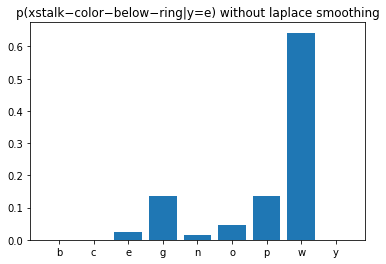

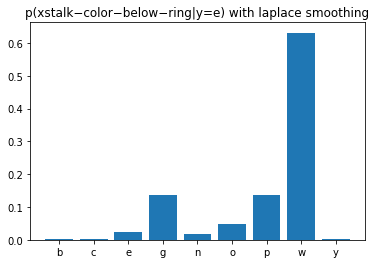

In [6]:
import csv

counts = {'n':0, 'b':0, 'c':0, 'g':0, 'o':0, 'p':0, 'e':0, 'w':0, 'y':0} # @ col 15
with open('data/agaricus-lepiota.data', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0] == 'e':
            counts[row[15]] += 1

# without laplace smoothing
wo_smooth = {k:v/sum(counts.values()) for k, v in sorted(counts.items())}
# with laplace smoothing with alpha
alpha = 10
w_smooth = {k:(v + alpha)/(len(counts.keys())*alpha + sum(counts.values()) ) for k, v in sorted(counts.items())}

plt.figure()
plt.title('p(xstalk−color−below−ring|y=e) without laplace smoothing')
plt.bar(wo_smooth.keys(), wo_smooth.values())
plt.show()

plt.title('p(xstalk−color−below−ring|y=e) with laplace smoothing')
plt.bar(w_smooth.keys(), w_smooth.values())
plt.show()
   

# Data visualization

因為原始的資料並不一定包含了所有的feature種類，為了避免少畫，我手動定義了所有的feature type
並在同一個 bar chart 中同時表示「在y = e」 「在y = p」和「全部的x」三種情況下的資料分佈

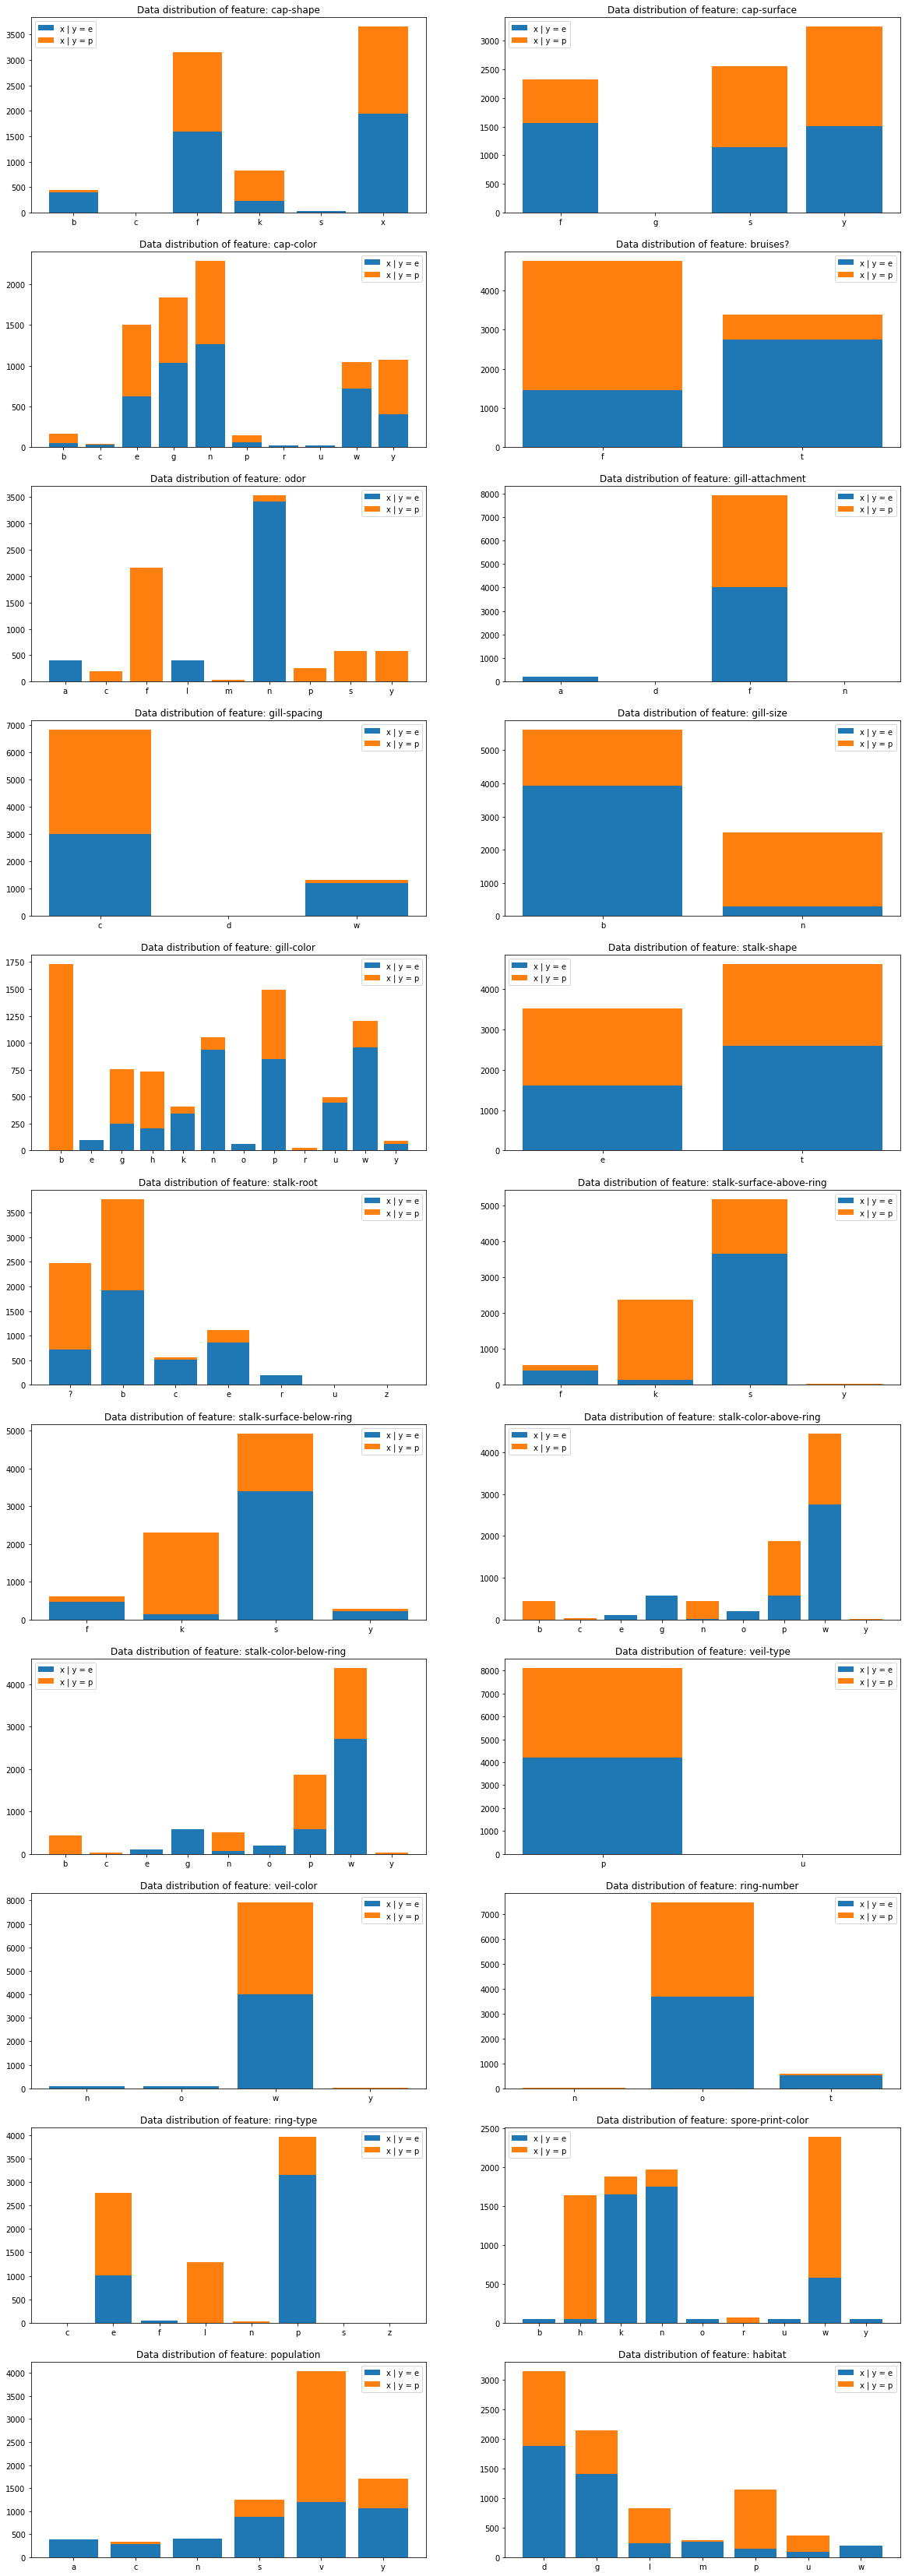

In [7]:
feature_names = ['cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor', 'gill-attachment',
'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 
'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
feature_types = [
    ['b', 'c', 'x', 'f', 'k', 's'],
    ['f', 'g', 'y', 's'],
    ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y'],
    ['t', 'f'],
    ['a', 'l', 'c', 'y', 'f', 'm', 'n', 'p', 's'],
    ['a', 'd', 'f', 'n'],
    ['c', 'w', 'd'],
    ['b', 'n'],
    ['k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y'],
    ['e', 't'],
    ['b', 'c', 'u', 'e', 'z', 'r', '?'],
    ['f', 'y', 'k', 's'],
    ['f', 'y', 'k', 's'],
    ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'],
    ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'],
    ['p', 'u'],
    ['n', 'o', 'w', 'y'],
    ['n', 'o', 't'],
    ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z'],
    ['k', 'n', 'b', 'h', 'r', 'o', 'u', 'w', 'y'],
    ['a', 'c', 'n', 's', 'v', 'y'],
    ['g', 'l', 'm', 'p', 'u', 'w', 'd']
]

def merged_plot_distribution(*xs):
    fig, axs = plt.subplots(11, 2, figsize=[20,60])
    for feature, (feature_name, feature_type) in enumerate(zip(feature_names, feature_types)):
        pre = None
        for name, x in xs:
            x_ticks, counts = np.unique(x[..., feature], return_counts=True)
            ax = axs[feature//2][feature%2]
            for t in feature_type:
                if t not in x_ticks:
                    x_ticks = np.append(x_ticks, t)
                    counts = np.append(counts, 0)
            arg = x_ticks.argsort()
            x_ticks = x_ticks[arg]
            counts = counts[arg]
            ax.bar(x_ticks, counts, bottom=pre, label=name)
            if pre is None:
                pre = counts
            else:
                pre += counts
        ax.set_title(f"Data distribution of feature: {feature_name}")
        ax.legend()
    plt.show()
        
x, y = raw_data[..., 1:], raw_data[..., 0]
x_e = x[np.where(y=='e')]
x_p = x[np.where(y=='p')]

merged_plot_distribution(('x | y = e', x_e), ('x | y = p' ,x_p))